## Word2vec for movie reviews

Build word2vec model using tensorflow, with movie review data (5331 positive and 5331 negative snippets) from http://www.cs.cornell.edu/people/pabo/movie-review-data

### Clean data

In [280]:
import numpy as np
import pandas as pd
import math
import re
import nltk
from nltk.tokenize import word_tokenize
import collections
import random
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

file_pos = open("rt-polarity-pos.txt", "r", encoding="ISO-8859-1")
data_pos = file_pos.readlines()
data_pos[:10]
file_neg = open("rt-polarity-neg.txt", "r", encoding="ISO-8859-1")
data_neg = file_neg.readlines()
data_neg[:10]

['simplistic , silly and tedious . \n',
 "it's so laddish and juvenile , only teenage boys could possibly find it funny . \n",
 'exploitative and largely devoid of the depth or sophistication that would make watching such a graphic treatment of the crimes bearable . \n',
 '[garbus] discards the potential for pathological study , exhuming instead , the skewed melodrama of the circumstantial situation . \n',
 'a visually flashy but narratively opaque and emotionally vapid exercise in style and mystification . \n',
 "the story is also as unoriginal as they come , already having been recycled more times than i'd care to count . \n",
 "about the only thing to give the movie points for is bravado -- to take an entirely stale concept and push it through the audience's meat grinder one more time . \n",
 'not so much farcical as sour . \n',
 'unfortunately the story and the actors are served with a hack script . \n',
 'all the more disquieting for its relatively gore-free allusions to the seria

In [69]:
df = pd.DataFrame([data_neg, data_pos]).T
df[:10]

,0,1
0,"simplistic , silly and tedious . \n",the rock is destined to be the 21st century's ...
1,"it's so laddish and juvenile , only teenage bo...","the gorgeously elaborate continuation of "" the..."
2,exploitative and largely devoid of the depth o...,effective but too-tepid biopic\n
3,[garbus] discards the potential for pathologic...,if you sometimes like to go to the movies to h...
4,a visually flashy but narratively opaque and e...,"emerges as something rare , an issue movie tha..."
5,"the story is also as unoriginal as they come ,...",the film provides some great insight into the ...
6,about the only thing to give the movie points ...,offers that rare combination of entertainment ...
7,not so much farcical as sour . \n,perhaps no picture ever made has more literall...
8,unfortunately the story and the actors are ser...,steers turns in a snappy screenplay that curls...
9,all the more disquieting for its relatively go...,take care of my cat offers a refreshingly diff...


In [264]:
#nltk.download('stopwords')
STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(text):
    text=text.lower()
    text = re.sub('@[^\s]+','', text)
    text = re.sub('#([^\s]+)', '', text)
    text = re.sub('[:;>?<=*+()&,\-#!$%\{˜|\}\[^_\\@\]1234567890’‘]',' ', text)
    text = re.sub('[\d]','', text)
    text = text.replace(".", '')
    text = text.replace("`", '')
    text = text.replace("'s", '')
    text = text.replace("/", ' ')
    text = text.replace("\"", ' ')
    text = text.replace("\\", '')
    text=re.sub( '\s+', ' ', text).strip()
    
    words = text.split(" ")
    for word in list(words):
    #    if word in STOP_WORDS:
    #        words.remove(word)
        if word == "":
            words.remove(word)
    return words

corpus = []
for sentence in df[:][0]:
    corpus.append(clean_sentence(sentence))
for sentence in df[:][1]:
    corpus.append(clean_sentence(sentence))
    
print(corpus[:5])

sample = sum(corpus, [])  ## make a list of all words

[['simplistic', 'silly', 'and', 'tedious'], ['it', 'so', 'laddish', 'and', 'juvenile', 'only', 'teenage', 'boys', 'could', 'possibly', 'find', 'it', 'funny'], ['exploitative', 'and', 'largely', 'devoid', 'of', 'the', 'depth', 'or', 'sophistication', 'that', 'would', 'make', 'watching', 'such', 'a', 'graphic', 'treatment', 'of', 'the', 'crimes', 'bearable'], ['garbus', 'discards', 'the', 'potential', 'for', 'pathological', 'study', 'exhuming', 'instead', 'the', 'skewed', 'melodrama', 'of', 'the', 'circumstantial', 'situation'], ['a', 'visually', 'flashy', 'but', 'narratively', 'opaque', 'and', 'emotionally', 'vapid', 'exercise', 'in', 'style', 'and', 'mystification']]
200926


In [273]:
#import zipfile
#def read_data(filename):
#  with zipfile.ZipFile(filename) as f:
#    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
#  return data
#read_data("text8.zip")

vocabulary = sample

print(vocabulary[:100])
print('Data size', len(vocabulary))

['simplistic', 'silly', 'and', 'tedious', 'it', 'so', 'laddish', 'and', 'juvenile', 'only', 'teenage', 'boys', 'could', 'possibly', 'find', 'it', 'funny', 'exploitative', 'and', 'largely', 'devoid', 'of', 'the', 'depth', 'or', 'sophistication', 'that', 'would', 'make', 'watching', 'such', 'a', 'graphic', 'treatment', 'of', 'the', 'crimes', 'bearable', 'garbus', 'discards', 'the', 'potential', 'for', 'pathological', 'study', 'exhuming', 'instead', 'the', 'skewed', 'melodrama', 'of', 'the', 'circumstantial', 'situation', 'a', 'visually', 'flashy', 'but', 'narratively', 'opaque', 'and', 'emotionally', 'vapid', 'exercise', 'in', 'style', 'and', 'mystification', 'the', 'story', 'is', 'also', 'as', 'unoriginal', 'as', 'they', 'come', 'already', 'having', 'been', 'recycled', 'more', 'times', 'than', "i'd", 'care', 'to', 'count', 'about', 'the', 'only', 'thing', 'to', 'give', 'the', 'movie', 'points', 'for', 'is', 'bravado']
Data size 200926


In [274]:
def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(
    vocabulary, vocabulary_size)

del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
  if data_index + span > len(data):
    data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
      buffer.extend(data[0:span])
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
        reverse_dictionary[labels[i, 0]])

Most common words (+UNK) [['UNK', 21398], ('the', 10194), ('a', 7336), ('and', 6264), ('of', 6148)]
Sample data [1184, 298, 3, 666, 6, 36, 0, 3, 3580, 62] ['simplistic', 'silly', 'and', 'tedious', 'it', 'so', 'UNK', 'and', 'juvenile', 'only']
298 silly -> 3 and
298 silly -> 1184 simplistic
3 and -> 666 tedious
3 and -> 298 silly
666 tedious -> 3 and
666 tedious -> 6 it
6 it -> 666 tedious
6 it -> 36 so


In [277]:
batch_size = 64
embedding_size = 512  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.

valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph = tf.Graph()

with graph.as_default():

  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  with tf.device('/cpu:0'):
    with tf.name_scope('embeddings'):
      embeddings = tf.Variable(
          tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
      embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    with tf.name_scope('weights'):
      nce_weights = tf.Variable(
          tf.truncated_normal(
              [vocabulary_size, embedding_size],
              stddev=1.0 / math.sqrt(embedding_size)))
    with tf.name_scope('biases'):
      nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

  tf.summary.scalar('loss', loss)

  with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  merged = tf.summary.merge_all()
  init = tf.global_variables_initializer()

# training.
num_steps = 200001
with tf.Session(graph=graph) as session:
  init.run()
  print('Initialized')

  average_loss = 0
  for step in range(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
    run_metadata = tf.RunMetadata()

    _, summary, loss_val = session.run(
        [optimizer, merged, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0
    
    if step % 20000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()


Initialized
Average loss at step  0 :  225.750976562
Nearest to there: dass, brilliance, total, chases, latter, bullets, like, acted,
Nearest to well: shoddy, succumbs, living, deadpan, nelson, revelation, achieve, cliches,
Nearest to us: plotline, r, devices, attempts, because, ironic, paying, sitting,
Nearest to even: swear, noir, remain, incessant, warner, bill, performers, recent,
Nearest to when: lights, somber, poignant, minor, sport, host, stolid, election,
Nearest to no: proceedings, adaptations, goes, academy, risky, thomas, maintain, found,
Nearest to your: speak, minimum, bruckheimer, intellectual, realize, resolutely, mary, animals,
Nearest to way: fathers, writers, suspect, walking, primitive, stay, art, background,
Nearest to new: off, education, narratively, clause, videos, sorority, testament, slip,
Nearest to you: sleeve, horrible, six, infectious, view, regardless, shelf, damaged,
Nearest to like: florid, associated, cletis, indie, james, aimed, hopes, there,
Nearest 

Average loss at step  94000 :  3.91425251389
Average loss at step  96000 :  3.91538287866
Average loss at step  98000 :  3.88745693612
Average loss at step  100000 :  3.90096821463
Nearest to there: it, not, of, i, UNK, that, we, with,
Nearest to well: hard, coppola, scene, movie, beer, sobering, background, smoochy,
Nearest to us: you, them, it, UNK, because, be, not, clear,
Nearest to even: UNK, it, obligatory, that, hard, m, suggest, easier,
Nearest to when: like, UNK, progress, poignant, lights, where, as, minor,
Nearest to no: nothing, a, any, plenty, holes, it, risky, woody,
Nearest to your: his, their, my, the, its, quentin, victims, dishonest,
Nearest to way: movie, fathers, UNK, cruel, miracle, as, background, asks,
Nearest to new: bizarre, the, narratively, imagine, setup, hybrid, dozen, addition,
Nearest to you: we, i, they, us, it, to, UNK, not,
Nearest to like: UNK, of, when, as, difference, that, retains, kong,
Nearest to may: will, would, might, can, to, doesn't, should,

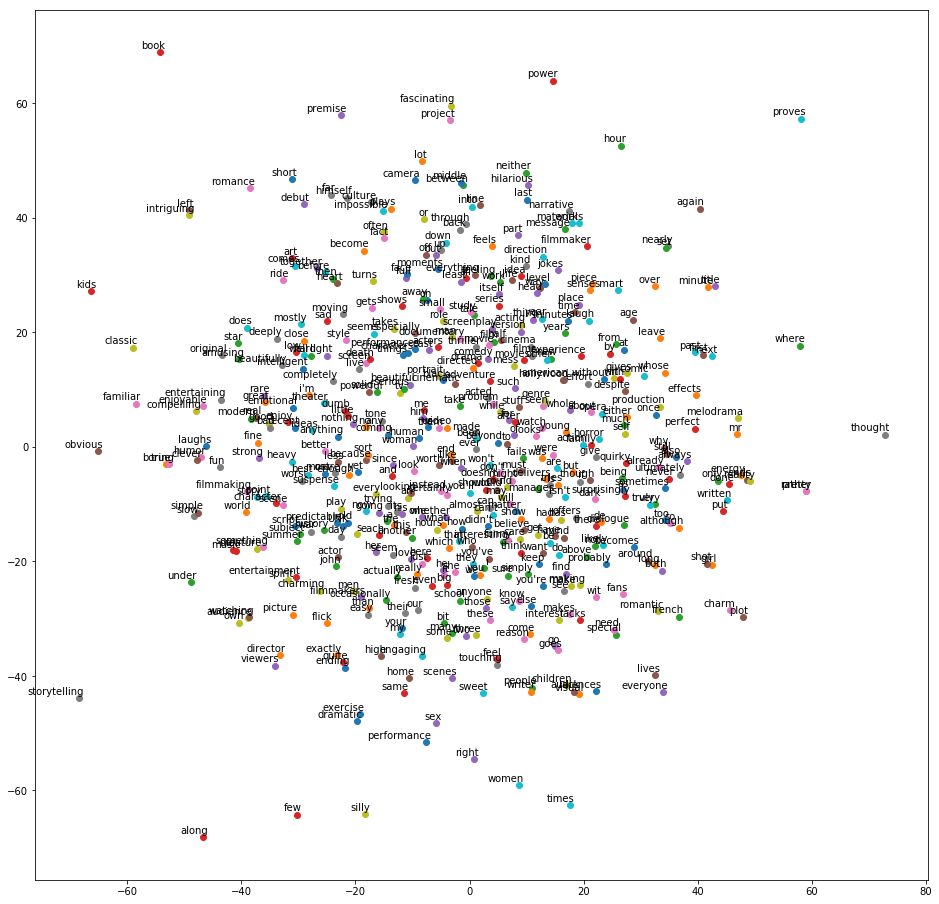

In [283]:
def plot_with_labels(low_dim_embs, labels):
  plt.figure(figsize=(16, 16))
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')


tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=1000, method='exact')
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)